# Hypersonic Flow Modeling

## Jonathan Taylor

In this project, I use concepts from linear algebra and numerical analysis to build regression models. The data used is from:

* https://github.com/paulcon/as-data-sets/tree/master/HyShotII


The data are from a simulation of a scramjet, which is an engine designed to achieve supersonic
speeds. It is expensive to construct, prototype, and test these engines, so often simulations
are used to explore the relevant parameter spaces. This dataset is from simulations of the HyShotII vehicle, and has the following input features:

1. angle of attack
2. turbulence intensity
3. turbulence length scale
4. stagnation pressure
5. stagnation enthalpy
6. cowl transition location

The output is the average of the pressure over the end of the engine. It is expensive to simulate this output, therefore the aim of this project is to train a model to predict the output based on the input variables.

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from Algorithms import OMP

## Helper Functions and Data Preprocessing

In [14]:
def Poly(X_train, p):
    """
    Generates a matrix of all polynomial combinations of the features
    with degree less than or equal to the specified degree p.

    Parameters
    ----------
    X_train : array_type, shape(m, n)
        Feature matrix whose feaures are to be combined.
    p : int
        Specifies the maximum degree of the polynomial features.

    Returns
    -------
    D : array_type, D(X_train, P)
        Matrix of polynomial combinations of features of degree p.
    """
    poly = PolynomialFeatures(p)
    D = poly.fit_transform(np.transpose(X_train))
    return D


def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-')

    
M = np.loadtxt('HyShotII30.txt', delimiter=",", dtype="double")
M = np.transpose(M)
M.shape
X = M[:7, :]
y = M[-1]

## Modeling using the Sparsity-inducing OMP Algorithm

Mean Relative Error after 20 Trials: 0.9356139456841334 %
Standard Deviation after 20 Trials 0.2663793128310692


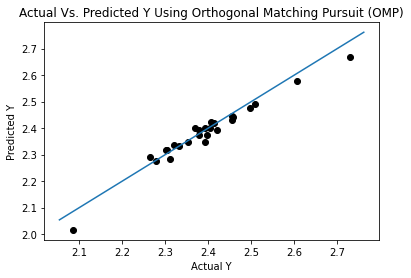

In [15]:
mean_errors = []
sd_errors = []
rel_error = []
n = 20
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(np.transpose(X), y,
                                                        test_size=0.50)
    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)
    A = Poly(X_train, 5)
    b = y_train
    x = OMP(A, b)
    y_pred = Poly(X_test, 5).dot(x)

    rel_error.append(np.linalg.norm(y_pred-y_test)/np.linalg.norm(y_test)
                     * 100)

mean_error = np.mean(rel_error)
sd_error = np.std(rel_error)

print("Mean Relative Error after 20 Trials:", mean_error, "%")
print("Standard Deviation after 20 Trials", sd_error)

plt.scatter(y_test, y_pred, color="black")
plt.xlabel("Actual Y")
plt.ylabel("Predicted Y")
plt.title("Actual Vs. Predicted Y Using Orthogonal Matching Pursuit (OMP)")
abline(1, 0)
plt.show()

## Modeling using the SVD

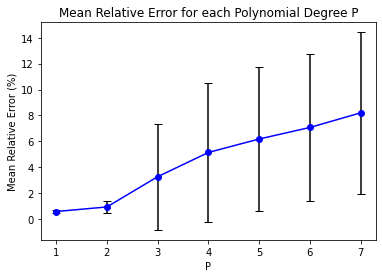

Mean Relative Error after 100 Trials: 0.556929621513736 %
Standard Deviation after 100 Trials 0.12288563847688262


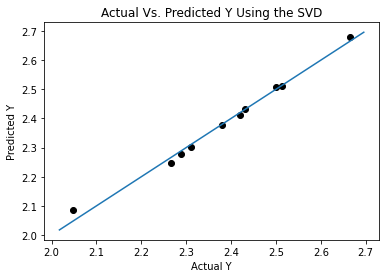

In [20]:
# determining the optimal polynomial p
rel_error = []
mean_errors = []
sd_errors = []
p = [1, 2, 3, 4, 5, 6, 7]
n = 10
for k in p:
    for m in range(n):
        X_train, X_test, y_train, y_test = train_test_split(np.transpose(X),
                                                            y, test_size=0.19)
        X_train = np.transpose(X_train)
        X_test = np.transpose(X_test)

        D = Poly(X_train, k)
        u, s, v = np.linalg.svd(D, full_matrices=False)

        a = s.shape[0]
        s_inv = np.zeros((a, a))
        for i in range(a):
            if s[i] != 0:
                s_inv[i, i] = 1 / s[i]

        u_inv = np.transpose(u)
        v_inv = np.transpose(v)

        Ap = v_inv.dot(s_inv).dot(u_inv)
        c = Ap.dot(y_train)
        y_pred = Poly(X_test, k).dot(c)

        rel_error.append(np.linalg.norm(y_pred-y_test)/np.linalg.norm(y_test)
                         * 100)

    mean_error = np.mean(rel_error)
    sd_error = np.std(rel_error)
    mean_errors.append(mean_error)
    sd_errors.append(sd_error)

fig, ax = plt.subplots()
ax.errorbar(p, mean_errors, yerr=sd_errors, marker="o",
            color="blue", ecolor="black", capsize=4)
plt.xlabel("P")
plt.ylabel("Mean Relative Error (%)")
plt.title("Mean Relative Error for each Polynomial Degree P")
plt.show()


# using optimal polynomial p = 1
p = 1

mean_errors = []
sd_errors = []
rel_error = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(np.transpose(X), y,
                                                        test_size=0.19)
    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)

    D = Poly(X_train, p)
    u, s, v = np.linalg.svd(D, full_matrices=False)

    a = s.shape[0]
    s_inv = np.zeros((a, a))
    for i in range(a):
        if s[i] != 0:
            s_inv[i, i] = 1 / s[i]

    u_inv = np.transpose(u)
    v_inv = np.transpose(v)

    Ap = v_inv.dot(s_inv).dot(u_inv)
    c = Ap.dot(y_train)
    y_pred = Poly(X_test, p).dot(c)

    rel_error.append(np.linalg.norm(y_pred-y_test)/np.linalg.norm(y_test)
                     * 100)

mean_error = np.mean(rel_error)
sd_error = np.std(rel_error)

print("Mean Relative Error after 100 Trials:", mean_error, "%")
print("Standard Deviation after 100 Trials", sd_error)


plt.scatter(y_pred, y_test, color="black")
plt.xlabel("Actual Y")
plt.ylabel("Predicted Y")
plt.title("Actual Vs. Predicted Y Using the SVD")
abline(1, 0)
plt.show()